In [3]:
from load_data_shuffle_separate import DataGeneratorPreFetch
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Visualize loading data

In [2]:
K = 2 # num_sample_per_classes
N = 5 # num_classes
B = 4

## Some functions for visualization
def plot_images(imgs, labels, n_col=N, title=None):
    plt.figure(figsize=(8, 2))
    n_row = np.ceil(len(imgs) / n_col).astype(int)
    for img_idx, (img, label) in enumerate(zip(imgs, labels)):
        plt.subplot(n_row, n_col, img_idx+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label.argmax())

    if title:
        plt.suptitle(title)
    plt.show()

### 1.2 Ordered generator 



Load data completed


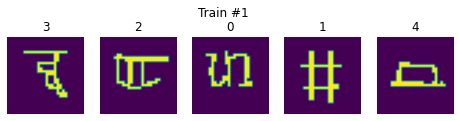

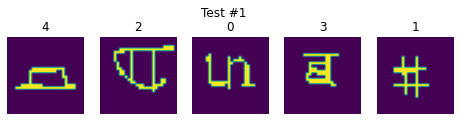

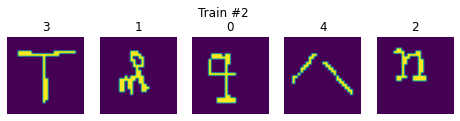

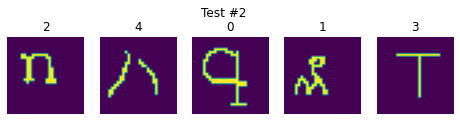

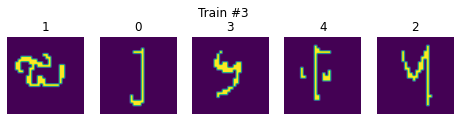

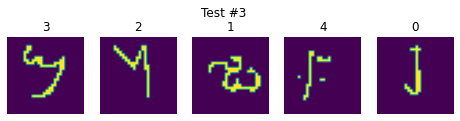

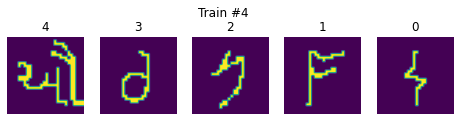

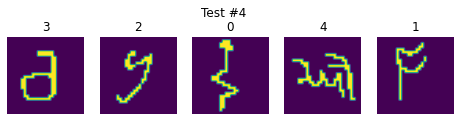

In [4]:
ordered_generator = DataGeneratorPreFetch(N, K)
batch_imgs, batch_labels = ordered_generator.sample_batch('train', B)

for i in range(B):
    images, labels = batch_imgs[i], batch_labels[i]
    train_images, train_labels = images[:-1].reshape(-1, 28, 28), labels[:-1].reshape(-1, N)  # K-1, N, N
    test_images, test_labels = images[-1:].reshape(-1, 28, 28), labels[-1:].reshape(-1, N) # 1, N, N

    plot_images(train_images, train_labels, n_col=N, title=f'Train #{i+1}')
    plot_images(test_images, test_labels, n_col=N, title=f'Test #{i+1}')

## 2. Training a model

### 2.1 Training a default model

In [5]:
num_classes = 2
num_samples = 1
meta_batch_size = 16

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from load_data_shuffle_separate import DataGeneratorPreFetch
from tensorflow.python.platform import flags


class MANN(nn.Module):
    def __init__(self, num_classes, sample_per_class, embed_size=784):
        super().__init__()
        self.num_classes = num_classes
        self.sample_per_classes = sample_per_class
        self.embed_size = embed_size
        self.lstm1 = nn.LSTM(embed_size + num_classes, 128)
        self.lstm2 = nn.LSTM(128, num_classes)

    def forward(self, input_images, raw_input_labels):
        # B, K+1, N, 784: input_images
        # B, K+1, N, N: input_labels
        B, k_plus_one, N, N = raw_input_labels.shape
        input_images = input_images.reshape(B, -1, self.embed_size)
        input_labels = raw_input_labels.copy().reshape(B, -1, N)
        input_labels[:, -self.num_classes:] = 0.
        x = torch.tensor(np.dstack((input_images, input_labels))).transpose(0, 1)  # (K+1)*N, B, N
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        return x  # ((K + 1)*N, B, N)


def train(num_classes, num_samples, meta_batch_size, print_every=100):
    data_generator = DataGeneratorPreFetch(
        num_classes, num_samples + 1)

    model = MANN(num_classes, num_samples + 1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    n_step = 50000
    test_accs = []

    for step in range(n_step):
        images, labels = data_generator.sample_batch('train', meta_batch_size)
        last_n_step_labels = labels[:, -1:].copy()
        last_n_step_labels = last_n_step_labels.squeeze(1).reshape(-1, num_classes)  # (B * N, N)
        target = torch.tensor(last_n_step_labels.argmax(axis=1))
        logits = model(images, labels)
        last_n_step_logits = logits[-num_classes:].\
            transpose(0, 1).contiguous().view(-1, num_classes)
        optimizer.zero_grad()
        loss = criterion(last_n_step_logits, target)
        loss.backward()
        optimizer.step()
        if step % print_every == 0:
            with torch.no_grad():
                print("*" * 5 + "Iter " + str(step) + "*" * 5)
                images, labels = data_generator.sample_batch('test', 100)
                last_n_step_labels = labels[:, -1:].copy()
                last_n_step_labels = last_n_step_labels.squeeze(1).reshape(-1, num_classes)  # (B * N, N)
                target = torch.tensor(last_n_step_labels.argmax(axis=1))
                logits = model(images, labels)
                last_n_step_logits = logits[-num_classes:].\
                    transpose(0, 1).contiguous().view(-1, num_classes)
                pred = last_n_step_logits.argmax(axis=1)
                test_loss = criterion(last_n_step_logits, target)

                print("Train Loss:", loss.item(), "Test Loss:", test_loss.item())
                test_accuracy = (1.0 * (pred == target)).mean().item()
                print("Test Accuracy", test_accuracy)
                test_accs.append(test_accuracy)

    import matplotlib.pyplot as plt
    plt.plot(range(len(test_accs)), test_accs)
    plt.xlabel("Step (x 100)")
    plt.ylabel("Test accuracy")
    plt.show()
    return model

Load data completed
*****Iter 0*****
Train Loss: 0.7005170583724976 Test Loss: 0.6957225799560547
Test Accuracy 0.4749999940395355
*****Iter 100*****
Train Loss: 0.6931712627410889 Test Loss: 0.6930399537086487
Test Accuracy 0.5149999856948853
*****Iter 200*****
Train Loss: 0.6931204795837402 Test Loss: 0.693157434463501
Test Accuracy 0.49000000953674316
*****Iter 300*****
Train Loss: 0.6932350397109985 Test Loss: 0.6930705308914185
Test Accuracy 0.45500001311302185
*****Iter 400*****
Train Loss: 0.6439601182937622 Test Loss: 0.6380272507667542
Test Accuracy 0.5
*****Iter 500*****
Train Loss: 0.6183202862739563 Test Loss: 0.6334022283554077
Test Accuracy 0.5149999856948853
*****Iter 600*****
Train Loss: 0.6224950551986694 Test Loss: 0.6159508228302002
Test Accuracy 0.47999998927116394
*****Iter 700*****
Train Loss: 0.602260172367096 Test Loss: 0.6164171099662781
Test Accuracy 0.49000000953674316
*****Iter 800*****
Train Loss: 0.5961090922355652 Test Loss: 0.6093175411224365
Test Accura

*****Iter 7200*****
Train Loss: 0.3512657880783081 Test Loss: 0.39888206124305725
Test Accuracy 0.8999999761581421
*****Iter 7300*****
Train Loss: 0.35881558060646057 Test Loss: 0.4004518985748291
Test Accuracy 0.9100000262260437
*****Iter 7400*****
Train Loss: 0.35270825028419495 Test Loss: 0.38675934076309204
Test Accuracy 0.925000011920929
*****Iter 7500*****
Train Loss: 0.3633338212966919 Test Loss: 0.38630858063697815
Test Accuracy 0.9200000166893005
*****Iter 7600*****
Train Loss: 0.36505311727523804 Test Loss: 0.4374309480190277
Test Accuracy 0.8700000047683716
*****Iter 7700*****
Train Loss: 0.3810352683067322 Test Loss: 0.36961469054222107
Test Accuracy 0.9399999976158142
*****Iter 7800*****
Train Loss: 0.3667742609977722 Test Loss: 0.3727257251739502
Test Accuracy 0.9399999976158142
*****Iter 7900*****
Train Loss: 0.3743467628955841 Test Loss: 0.40770119428634644
Test Accuracy 0.8999999761581421
*****Iter 8000*****
Train Loss: 0.36499640345573425 Test Loss: 0.3812184929847717

*****Iter 14300*****
Train Loss: 0.34981992840766907 Test Loss: 0.3882341682910919
Test Accuracy 0.9300000071525574
*****Iter 14400*****
Train Loss: 0.3551320731639862 Test Loss: 0.3852212429046631
Test Accuracy 0.9200000166893005
*****Iter 14500*****
Train Loss: 0.34015095233917236 Test Loss: 0.3911244571208954
Test Accuracy 0.925000011920929
*****Iter 14600*****
Train Loss: 0.3491915166378021 Test Loss: 0.35606229305267334
Test Accuracy 0.9549999833106995
*****Iter 14700*****
Train Loss: 0.3489164113998413 Test Loss: 0.3750467300415039
Test Accuracy 0.925000011920929
*****Iter 14800*****
Train Loss: 0.3462413251399994 Test Loss: 0.3717311918735504
Test Accuracy 0.9399999976158142
*****Iter 14900*****
Train Loss: 0.3496403098106384 Test Loss: 0.38532447814941406
Test Accuracy 0.925000011920929
*****Iter 15000*****
Train Loss: 0.3720967471599579 Test Loss: 0.3602043092250824
Test Accuracy 0.9449999928474426
*****Iter 15100*****
Train Loss: 0.34147945046424866 Test Loss: 0.4039027392864

*****Iter 21400*****
Train Loss: 0.3437482714653015 Test Loss: 0.3726728558540344
Test Accuracy 0.9399999976158142
*****Iter 21500*****
Train Loss: 0.33693233132362366 Test Loss: 0.36201441287994385
Test Accuracy 0.9549999833106995
*****Iter 21600*****
Train Loss: 0.3401161730289459 Test Loss: 0.34638795256614685
Test Accuracy 0.9700000286102295
*****Iter 21700*****
Train Loss: 0.34009695053100586 Test Loss: 0.3384527862071991
Test Accuracy 0.9900000095367432
*****Iter 21800*****
Train Loss: 0.33675500750541687 Test Loss: 0.35282254219055176
Test Accuracy 0.9649999737739563
*****Iter 21900*****
Train Loss: 0.3549731373786926 Test Loss: 0.36277666687965393
Test Accuracy 0.949999988079071
*****Iter 22000*****
Train Loss: 0.3415101170539856 Test Loss: 0.3669409155845642
Test Accuracy 0.9449999928474426
*****Iter 22100*****
Train Loss: 0.34565073251724243 Test Loss: 0.3346264660358429
Test Accuracy 0.9800000190734863
*****Iter 22200*****
Train Loss: 0.34646129608154297 Test Loss: 0.3960331

*****Iter 28500*****
Train Loss: 0.3406839668750763 Test Loss: 0.3807245194911957
Test Accuracy 0.9449999928474426
*****Iter 28600*****
Train Loss: 0.33246269822120667 Test Loss: 0.409828782081604
Test Accuracy 0.8899999856948853
*****Iter 28700*****
Train Loss: 0.34351736307144165 Test Loss: 0.38662976026535034
Test Accuracy 0.925000011920929
*****Iter 28800*****
Train Loss: 0.3323163092136383 Test Loss: 0.3730624318122864
Test Accuracy 0.9300000071525574
*****Iter 28900*****
Train Loss: 0.3479663133621216 Test Loss: 0.36983242630958557
Test Accuracy 0.9449999928474426
*****Iter 29000*****
Train Loss: 0.33664318919181824 Test Loss: 0.3594590127468109
Test Accuracy 0.9549999833106995
*****Iter 29100*****
Train Loss: 0.3308876156806946 Test Loss: 0.3676505386829376
Test Accuracy 0.9449999928474426
*****Iter 29200*****
Train Loss: 0.34183990955352783 Test Loss: 0.3627166748046875
Test Accuracy 0.949999988079071
*****Iter 29300*****
Train Loss: 0.33687371015548706 Test Loss: 0.40330296754

*****Iter 35600*****
Train Loss: 0.3396450877189636 Test Loss: 0.3958854377269745
Test Accuracy 0.9150000214576721
*****Iter 35700*****
Train Loss: 0.34303387999534607 Test Loss: 0.38410434126853943
Test Accuracy 0.925000011920929
*****Iter 35800*****
Train Loss: 0.33940771222114563 Test Loss: 0.41562139987945557
Test Accuracy 0.8849999904632568
*****Iter 35900*****
Train Loss: 0.33680078387260437 Test Loss: 0.356130450963974
Test Accuracy 0.9599999785423279
*****Iter 36000*****
Train Loss: 0.3395899832248688 Test Loss: 0.37420886754989624
Test Accuracy 0.9399999976158142
*****Iter 36100*****
Train Loss: 0.33210304379463196 Test Loss: 0.37244465947151184
Test Accuracy 0.9449999928474426
*****Iter 36200*****
Train Loss: 0.33080458641052246 Test Loss: 0.3550664782524109
Test Accuracy 0.9599999785423279
*****Iter 36300*****
Train Loss: 0.33338168263435364 Test Loss: 0.39127883315086365
Test Accuracy 0.925000011920929
*****Iter 36400*****
Train Loss: 0.33350005745887756 Test Loss: 0.352527

*****Iter 42700*****
Train Loss: 0.3286791443824768 Test Loss: 0.3448410928249359
Test Accuracy 0.9700000286102295
*****Iter 42800*****
Train Loss: 0.3342788517475128 Test Loss: 0.3951150178909302
Test Accuracy 0.9049999713897705
*****Iter 42900*****
Train Loss: 0.3378596305847168 Test Loss: 0.3613854646682739
Test Accuracy 0.949999988079071
*****Iter 43000*****
Train Loss: 0.34189674258232117 Test Loss: 0.39361846446990967
Test Accuracy 0.9100000262260437
*****Iter 43100*****
Train Loss: 0.3239413797855377 Test Loss: 0.354070246219635
Test Accuracy 0.9649999737739563
*****Iter 43200*****
Train Loss: 0.3260084092617035 Test Loss: 0.3610319197177887
Test Accuracy 0.949999988079071
*****Iter 43300*****
Train Loss: 0.3197922110557556 Test Loss: 0.3619421720504761
Test Accuracy 0.949999988079071
*****Iter 43400*****
Train Loss: 0.3319556415081024 Test Loss: 0.352451890707016
Test Accuracy 0.9599999785423279
*****Iter 43500*****
Train Loss: 0.32992351055145264 Test Loss: 0.329468697309494
T

*****Iter 49800*****
Train Loss: 0.3303033113479614 Test Loss: 0.36608588695526123
Test Accuracy 0.9449999928474426
*****Iter 49900*****
Train Loss: 0.3344232439994812 Test Loss: 0.3793248236179352
Test Accuracy 0.9350000023841858


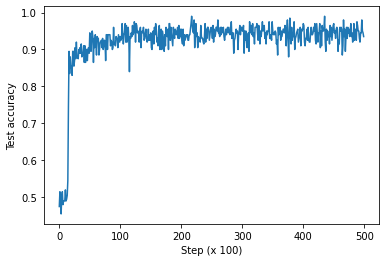

In [9]:
model_k1n2 = train(num_classes=2, num_samples=1, meta_batch_size=256, print_every=100, n_step=2000)

### 2.2 Visualize model prediction

In [10]:
data_generator = DataGeneratorPreFetch(num_classes, num_samples + 1)

Load data completed


In [11]:
def plot_prediction(imgs, true_labels, predict_labels=None, n_col=num_classes, title=None):
    plt.figure(figsize=(8, 3))
    n_row = np.ceil(len(imgs) / n_col).astype(int)
    for img_idx in range(len(imgs)):
        img, label = imgs[img_idx], true_labels[img_idx]
        plt.subplot(n_row, n_col, img_idx+1)
        plt.imshow(img)
        plt.axis('off')
        if predict_labels is not None:
            sub_title = f"Pred: {predict_labels[img_idx].argmax()} (Actual: {label.argmax()})"
            if predict_labels[img_idx].argmax() == label.argmax():
                sub_title = ""
        else:
            sub_title = str(label.argmax())
        plt.title(sub_title)

    if title:
        plt.suptitle(title)
    plt.show()

torch.Size([20, 2, 2])


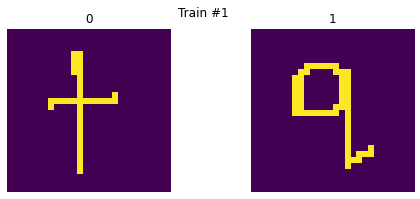

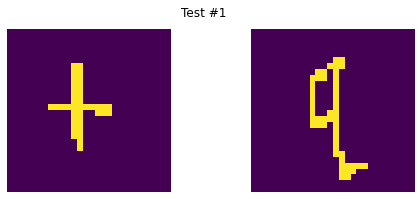

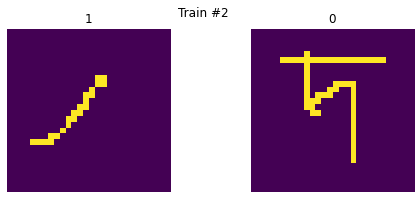

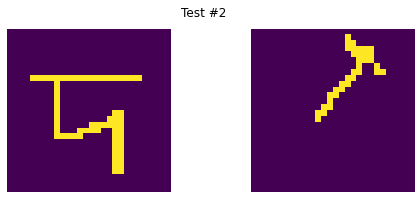

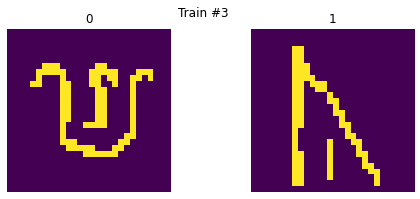

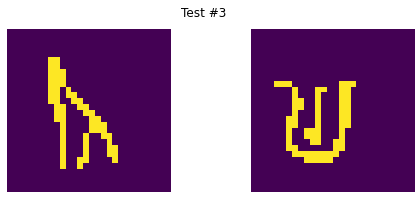

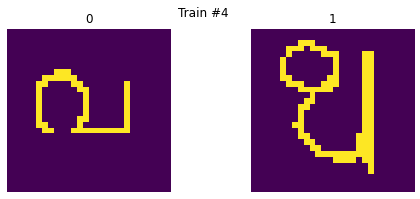

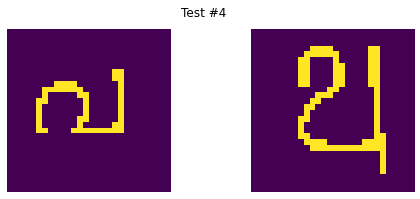

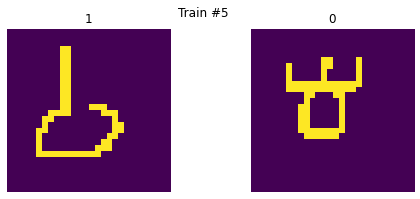

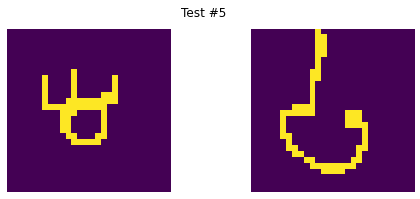

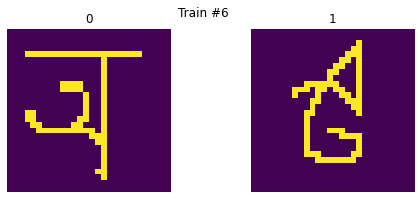

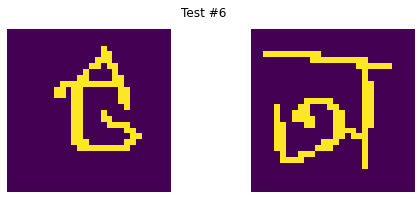

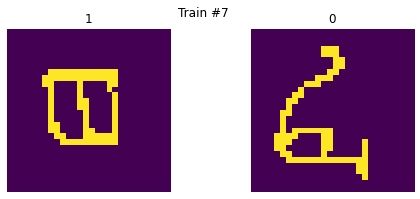

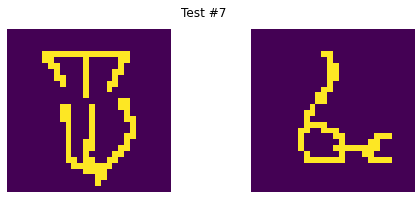

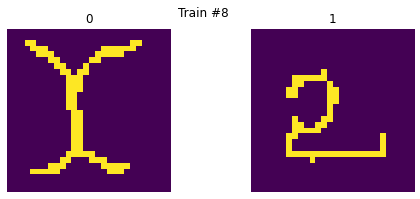

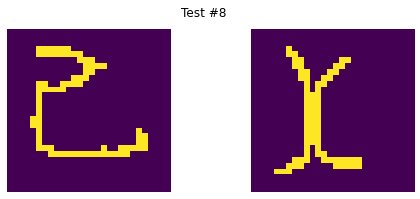

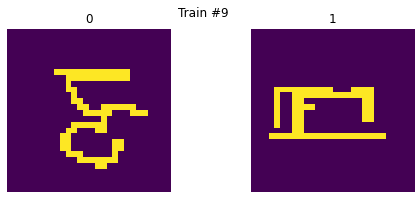

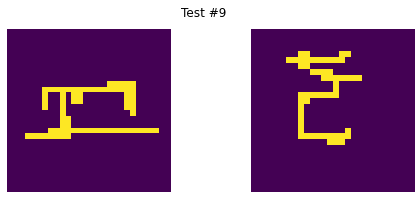

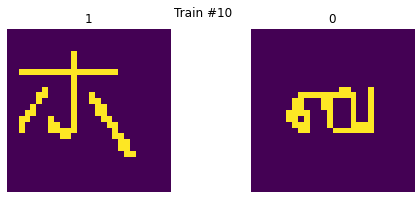

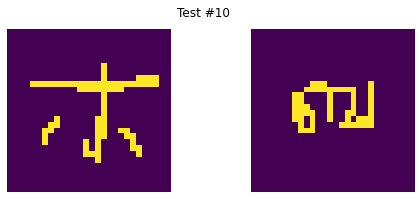

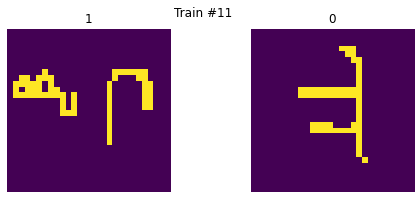

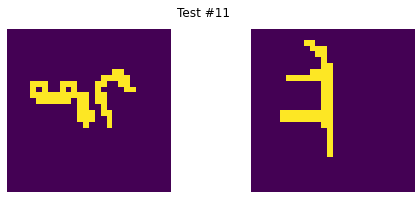

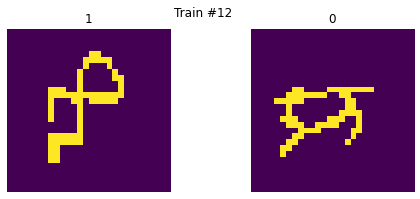

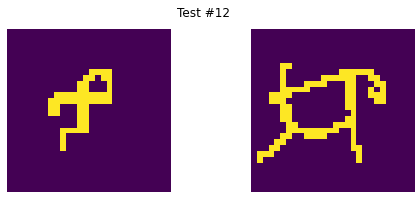

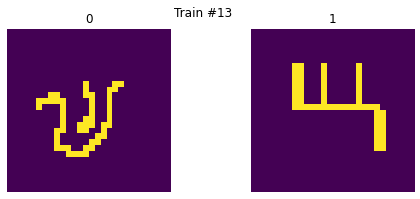

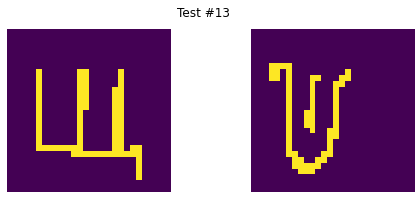

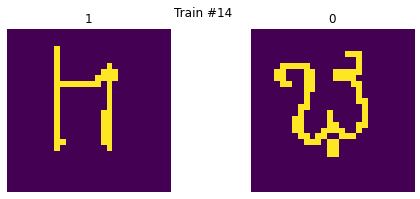

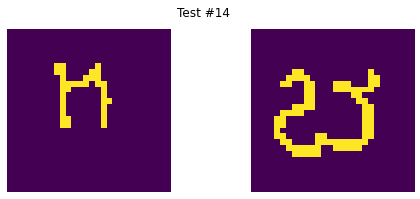

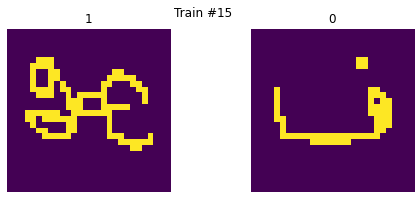

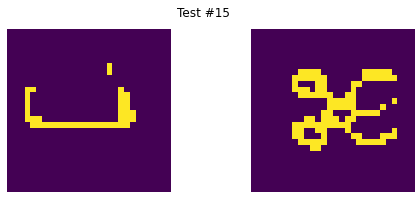

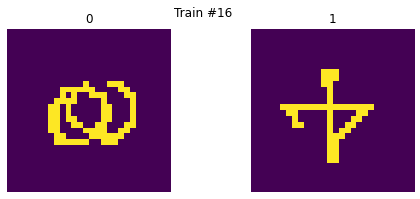

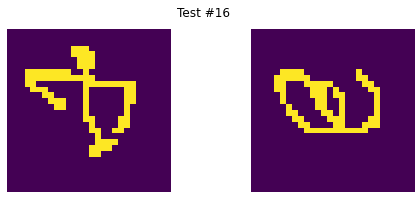

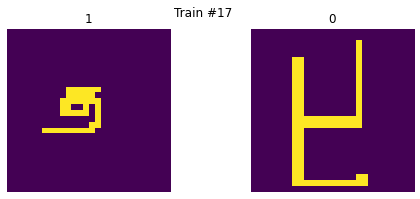

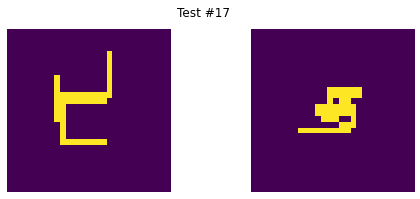

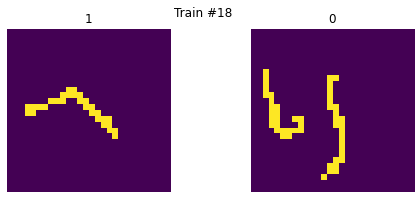

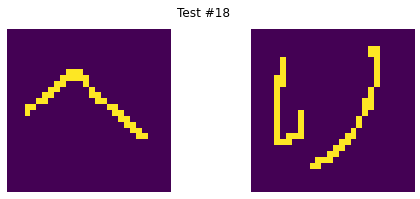

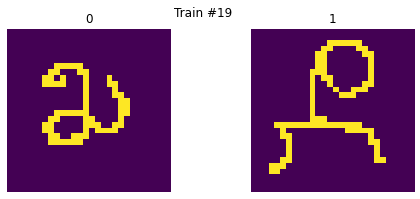

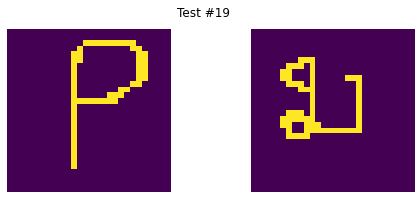

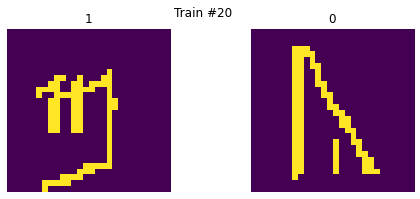

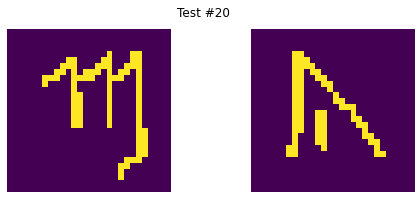

In [12]:
batch_images, batch_labels = data_generator.sample_batch('test', batch_size=20)

with torch.no_grad():
    batch_labels_infer = batch_labels.copy()
    last_n_step_labels = batch_labels[:, -1:]
    last_n_step_labels = last_n_step_labels.squeeze(1).reshape(-1, num_classes)  # (B * N, N)
    logits = model_k1n2(batch_images, batch_labels_infer)
    last_n_step_logits = logits[-num_classes:].transpose(0, 1).contiguous()
    print(last_n_step_logits.shape)

for i in range(20):
    images, labels, predictions = batch_images[i], batch_labels[i], last_n_step_logits[i]
    train_images, train_labels = images[:-1].reshape(-1, 28, 28), labels[:-1].reshape(-1, num_classes)  # K-1, N, N
    test_images, test_labels = images[-1:].reshape(-1, 28, 28), labels[-1:].reshape(-1, num_classes) # 1, N, N
    
    plot_prediction(train_images, train_labels, n_col=num_classes, title=f'Train #{i+1}')
    plot_prediction(test_images, test_labels, predictions, n_col=num_classes, title=f'Test #{i+1}')

## Train model with N=3 and N=4

### Please be careful when zero-out test labels, it can silently f**k your evaluation for weeks 

Load data completed
*****Iter 0*****
Train Loss: 1.1067363023757935 Test Loss: 1.0969089269638062
Test Accuracy 0.36000001430511475
*****Iter 100*****
Train Loss: 1.0984565019607544 Test Loss: 1.0987592935562134
Test Accuracy 0.3499999940395355
*****Iter 200*****
Train Loss: 1.0985525846481323 Test Loss: 1.0982067584991455
Test Accuracy 0.3499999940395355
*****Iter 300*****
Train Loss: 1.0985745191574097 Test Loss: 1.09864342212677
Test Accuracy 0.3466666638851166
*****Iter 400*****
Train Loss: 1.098636507987976 Test Loss: 1.098622441291809
Test Accuracy 0.3499999940395355
*****Iter 500*****
Train Loss: 1.0985114574432373 Test Loss: 1.0985307693481445
Test Accuracy 0.33000001311302185
*****Iter 600*****
Train Loss: 1.0986049175262451 Test Loss: 1.0986427068710327
Test Accuracy 0.36666667461395264
*****Iter 700*****
Train Loss: 1.0985832214355469 Test Loss: 1.098606824874878
Test Accuracy 0.3166666626930237
*****Iter 800*****
Train Loss: 1.0986080169677734 Test Loss: 1.0986000299453735


*****Iter 7200*****
Train Loss: 0.8653709888458252 Test Loss: 0.9188860058784485
Test Accuracy 0.5099999904632568
*****Iter 7300*****
Train Loss: 0.8423083424568176 Test Loss: 0.8698530793190002
Test Accuracy 0.5366666913032532
*****Iter 7400*****
Train Loss: 0.8575645089149475 Test Loss: 0.9073870778083801
Test Accuracy 0.5333333611488342
*****Iter 7500*****
Train Loss: 0.8229617476463318 Test Loss: 0.8832090497016907
Test Accuracy 0.5600000023841858
*****Iter 7600*****
Train Loss: 0.8715972304344177 Test Loss: 0.8923354148864746
Test Accuracy 0.5199999809265137
*****Iter 7700*****
Train Loss: 0.8465884327888489 Test Loss: 0.851700484752655
Test Accuracy 0.5566666722297668
*****Iter 7800*****
Train Loss: 0.8262748718261719 Test Loss: 0.8699496388435364
Test Accuracy 0.550000011920929
*****Iter 7900*****
Train Loss: 0.8585037589073181 Test Loss: 0.8804057836532593
Test Accuracy 0.54666668176651
*****Iter 8000*****
Train Loss: 0.8335869312286377 Test Loss: 0.8918144702911377
Test Accura

*****Iter 14500*****
Train Loss: 0.6610201001167297 Test Loss: 0.7324908971786499
Test Accuracy 0.753333330154419
*****Iter 14600*****
Train Loss: 0.6057548522949219 Test Loss: 0.6719623804092407
Test Accuracy 0.79666668176651
*****Iter 14700*****
Train Loss: 0.6223843693733215 Test Loss: 0.7037510275840759
Test Accuracy 0.7699999809265137
*****Iter 14800*****
Train Loss: 0.6880228519439697 Test Loss: 0.7441181540489197
Test Accuracy 0.7166666388511658
*****Iter 14900*****
Train Loss: 0.6428353190422058 Test Loss: 0.6934866905212402
Test Accuracy 0.800000011920929
*****Iter 15000*****
Train Loss: 0.6223819851875305 Test Loss: 0.747925341129303
Test Accuracy 0.7233333587646484
*****Iter 15100*****
Train Loss: 0.7016785144805908 Test Loss: 0.6830748319625854
Test Accuracy 0.7833333611488342
*****Iter 15200*****
Train Loss: 0.6158824563026428 Test Loss: 0.7012708187103271
Test Accuracy 0.7633333206176758
*****Iter 15300*****
Train Loss: 0.6688441634178162 Test Loss: 0.7023143768310547
Tes

*****Iter 21700*****
Train Loss: 0.6602210402488708 Test Loss: 0.6251910924911499
Test Accuracy 0.8399999737739563
*****Iter 21800*****
Train Loss: 0.64556485414505 Test Loss: 0.6888605356216431
Test Accuracy 0.746666669845581
*****Iter 21900*****
Train Loss: 0.5746109485626221 Test Loss: 0.6645433306694031
Test Accuracy 0.7866666913032532
*****Iter 22000*****
Train Loss: 0.5678758025169373 Test Loss: 0.6445241570472717
Test Accuracy 0.8100000023841858
*****Iter 22100*****
Train Loss: 0.596245527267456 Test Loss: 0.6636974811553955
Test Accuracy 0.7766666412353516
*****Iter 22200*****
Train Loss: 0.527588427066803 Test Loss: 0.632905125617981
Test Accuracy 0.8166666626930237
*****Iter 22300*****
Train Loss: 0.6221246719360352 Test Loss: 0.6567939519882202
Test Accuracy 0.8066666722297668
*****Iter 22400*****
Train Loss: 0.5944502949714661 Test Loss: 0.6683878898620605
Test Accuracy 0.800000011920929
*****Iter 22500*****
Train Loss: 0.6226726174354553 Test Loss: 0.6831235885620117
Test 

*****Iter 28900*****
Train Loss: 0.557238757610321 Test Loss: 0.5911903977394104
Test Accuracy 0.8533333539962769
*****Iter 29000*****
Train Loss: 0.5625090003013611 Test Loss: 0.660916805267334
Test Accuracy 0.7833333611488342
*****Iter 29100*****
Train Loss: 0.5904296040534973 Test Loss: 0.6309937834739685
Test Accuracy 0.8100000023841858
*****Iter 29200*****
Train Loss: 0.6073368787765503 Test Loss: 0.6399333477020264
Test Accuracy 0.8266666531562805
*****Iter 29300*****
Train Loss: 0.5431914925575256 Test Loss: 0.6918998956680298
Test Accuracy 0.7699999809265137
*****Iter 29400*****
Train Loss: 0.5934115052223206 Test Loss: 0.6063467860221863
Test Accuracy 0.8666666746139526
*****Iter 29500*****
Train Loss: 0.5520745515823364 Test Loss: 0.7095957398414612
Test Accuracy 0.7433333396911621
*****Iter 29600*****
Train Loss: 0.615040123462677 Test Loss: 0.6524797081947327
Test Accuracy 0.7833333611488342
*****Iter 29700*****
Train Loss: 0.6689925789833069 Test Loss: 0.6764064431190491
T

*****Iter 36100*****
Train Loss: 0.5753974318504333 Test Loss: 0.6795253753662109
Test Accuracy 0.79666668176651
*****Iter 36200*****
Train Loss: 0.5657110810279846 Test Loss: 0.6175170540809631
Test Accuracy 0.8233333230018616
*****Iter 36300*****
Train Loss: 0.5405759215354919 Test Loss: 0.5782821774482727
Test Accuracy 0.8799999952316284
*****Iter 36400*****
Train Loss: 0.567294716835022 Test Loss: 0.6665138602256775
Test Accuracy 0.800000011920929
*****Iter 36500*****
Train Loss: 0.601146936416626 Test Loss: 0.6618629097938538
Test Accuracy 0.7833333611488342
*****Iter 36600*****
Train Loss: 0.5981804132461548 Test Loss: 0.6302181482315063
Test Accuracy 0.8366666436195374
*****Iter 36700*****
Train Loss: 0.5369711518287659 Test Loss: 0.6554185748100281
Test Accuracy 0.8066666722297668
*****Iter 36800*****
Train Loss: 0.5641449689865112 Test Loss: 0.6528357267379761
Test Accuracy 0.8199999928474426
*****Iter 36900*****
Train Loss: 0.6098600625991821 Test Loss: 0.6339154839515686
Tes

*****Iter 43300*****
Train Loss: 0.5691295266151428 Test Loss: 0.6812170147895813
Test Accuracy 0.7566666603088379
*****Iter 43400*****
Train Loss: 0.5412960648536682 Test Loss: 0.5751384496688843
Test Accuracy 0.8733333349227905
*****Iter 43500*****
Train Loss: 0.554050624370575 Test Loss: 0.7042213678359985
Test Accuracy 0.7733333110809326
*****Iter 43600*****
Train Loss: 0.5571907758712769 Test Loss: 0.6845036745071411
Test Accuracy 0.7799999713897705
*****Iter 43700*****
Train Loss: 0.5507083535194397 Test Loss: 0.6443230509757996
Test Accuracy 0.7866666913032532
*****Iter 43800*****
Train Loss: 0.576574444770813 Test Loss: 0.6034174561500549
Test Accuracy 0.8533333539962769
*****Iter 43900*****
Train Loss: 0.5421512722969055 Test Loss: 0.6622215509414673
Test Accuracy 0.8066666722297668
*****Iter 44000*****
Train Loss: 0.5680243372917175 Test Loss: 0.6264634132385254
Test Accuracy 0.8366666436195374
*****Iter 44100*****
Train Loss: 0.5295082926750183 Test Loss: 0.6451305747032166


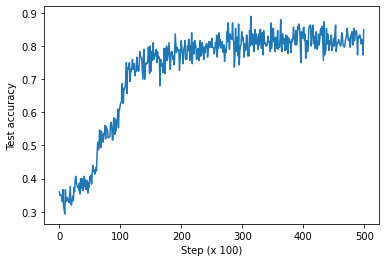

In [13]:
model_k1n3 = train(num_classes=3, num_samples=1, meta_batch_size=64, print_every=100)

Load data completed
*****Iter 0*****
Train Loss: 1.4074230194091797 Test Loss: 1.3914666175842285
Test Accuracy 0.2524999976158142
*****Iter 100*****
Train Loss: 1.386248230934143 Test Loss: 1.3861030340194702
Test Accuracy 0.2475000023841858
*****Iter 200*****
Train Loss: 1.3860112428665161 Test Loss: 1.3864529132843018
Test Accuracy 0.22499999403953552
*****Iter 300*****
Train Loss: 1.3865079879760742 Test Loss: 1.3864353895187378
Test Accuracy 0.25
*****Iter 400*****
Train Loss: 1.3862956762313843 Test Loss: 1.3862727880477905
Test Accuracy 0.26499998569488525
*****Iter 500*****
Train Loss: 1.3862144947052002 Test Loss: 1.3862582445144653
Test Accuracy 0.25999999046325684
*****Iter 600*****
Train Loss: 1.3863133192062378 Test Loss: 1.3863334655761719
Test Accuracy 0.26249998807907104
*****Iter 700*****
Train Loss: 1.3862749338150024 Test Loss: 1.3862900733947754
Test Accuracy 0.2475000023841858
*****Iter 800*****
Train Loss: 1.386309266090393 Test Loss: 1.3863056898117065
Test Accur

*****Iter 7500*****
Train Loss: 1.3862942457199097 Test Loss: 1.3862937688827515
Test Accuracy 0.25
*****Iter 7600*****
Train Loss: 1.3862924575805664 Test Loss: 1.3862922191619873
Test Accuracy 0.25
*****Iter 7700*****
Train Loss: 1.3862941265106201 Test Loss: 1.386288046836853
Test Accuracy 0.25
*****Iter 7800*****
Train Loss: 1.386293888092041 Test Loss: 1.3862918615341187
Test Accuracy 0.2524999976158142
*****Iter 7900*****
Train Loss: 1.386238694190979 Test Loss: 1.3838706016540527
Test Accuracy 0.26499998569488525
*****Iter 8000*****
Train Loss: 1.3825217485427856 Test Loss: 1.385063648223877
Test Accuracy 0.23250000178813934
*****Iter 8100*****
Train Loss: 1.3699358701705933 Test Loss: 1.3761881589889526
Test Accuracy 0.32249999046325684
*****Iter 8200*****
Train Loss: 1.366530179977417 Test Loss: 1.364898681640625
Test Accuracy 0.3075000047683716
*****Iter 8300*****
Train Loss: 1.3493787050247192 Test Loss: 1.3548091650009155
Test Accuracy 0.30000001192092896
*****Iter 8400****

*****Iter 14800*****
Train Loss: 0.9981637001037598 Test Loss: 1.1735260486602783
Test Accuracy 0.48500001430511475
*****Iter 14900*****
Train Loss: 1.071580171585083 Test Loss: 1.129360318183899
Test Accuracy 0.5375000238418579
*****Iter 15000*****
Train Loss: 1.0665757656097412 Test Loss: 1.1698431968688965
Test Accuracy 0.48500001430511475
*****Iter 15100*****
Train Loss: 1.037150502204895 Test Loss: 1.1172852516174316
Test Accuracy 0.5550000071525574
*****Iter 15200*****
Train Loss: 1.0496858358383179 Test Loss: 1.1075334548950195
Test Accuracy 0.5325000286102295
*****Iter 15300*****
Train Loss: 1.0642671585083008 Test Loss: 1.0964131355285645
Test Accuracy 0.550000011920929
*****Iter 15400*****
Train Loss: 1.0509542226791382 Test Loss: 1.1247615814208984
Test Accuracy 0.5350000262260437
*****Iter 15500*****
Train Loss: 1.0774354934692383 Test Loss: 1.1514168977737427
Test Accuracy 0.5149999856948853
*****Iter 15600*****
Train Loss: 1.047778844833374 Test Loss: 1.0804743766784668
T

*****Iter 22100*****
Train Loss: 0.9022476077079773 Test Loss: 1.0693042278289795
Test Accuracy 0.5950000286102295
*****Iter 22200*****
Train Loss: 0.9290922284126282 Test Loss: 1.0802065134048462
Test Accuracy 0.5849999785423279
*****Iter 22300*****
Train Loss: 0.9555144906044006 Test Loss: 1.0780853033065796
Test Accuracy 0.6200000047683716
*****Iter 22400*****
Train Loss: 0.9757315516471863 Test Loss: 1.083368182182312
Test Accuracy 0.5899999737739563
*****Iter 22500*****
Train Loss: 0.9646997451782227 Test Loss: 1.090125560760498
Test Accuracy 0.612500011920929
*****Iter 22600*****
Train Loss: 0.9370619058609009 Test Loss: 1.123665690422058
Test Accuracy 0.6025000214576721
*****Iter 22700*****
Train Loss: 0.9583239555358887 Test Loss: 1.068108320236206
Test Accuracy 0.637499988079071
*****Iter 22800*****
Train Loss: 0.9500722885131836 Test Loss: 1.1078410148620605
Test Accuracy 0.5575000047683716
*****Iter 22900*****
Train Loss: 0.9536373019218445 Test Loss: 1.0789698362350464
Test

*****Iter 29300*****
Train Loss: 0.8571987748146057 Test Loss: 1.0724858045578003
Test Accuracy 0.6424999833106995
*****Iter 29400*****
Train Loss: 0.8849136233329773 Test Loss: 1.0855516195297241
Test Accuracy 0.6100000143051147
*****Iter 29500*****
Train Loss: 0.8987727165222168 Test Loss: 1.0926026105880737
Test Accuracy 0.5674999952316284
*****Iter 29600*****
Train Loss: 0.8932648301124573 Test Loss: 1.0875216722488403
Test Accuracy 0.6075000166893005
*****Iter 29700*****
Train Loss: 0.8783634901046753 Test Loss: 1.1273590326309204
Test Accuracy 0.5550000071525574
*****Iter 29800*****
Train Loss: 0.8989881277084351 Test Loss: 1.0864163637161255
Test Accuracy 0.6225000023841858
*****Iter 29900*****
Train Loss: 0.91007000207901 Test Loss: 1.107607126235962
Test Accuracy 0.5899999737739563
*****Iter 30000*****
Train Loss: 0.8691064119338989 Test Loss: 1.1066380739212036
Test Accuracy 0.6025000214576721
*****Iter 30100*****
Train Loss: 0.8871658444404602 Test Loss: 1.121903657913208
Te

*****Iter 36600*****
Train Loss: 0.8397390246391296 Test Loss: 1.1328145265579224
Test Accuracy 0.5950000286102295
*****Iter 36700*****
Train Loss: 0.8746103644371033 Test Loss: 1.1660553216934204
Test Accuracy 0.5525000095367432
*****Iter 36800*****
Train Loss: 0.8472298383712769 Test Loss: 1.1115530729293823
Test Accuracy 0.5975000262260437
*****Iter 36900*****
Train Loss: 0.8462305665016174 Test Loss: 1.16087007522583
Test Accuracy 0.5475000143051147
*****Iter 37000*****
Train Loss: 0.8712239265441895 Test Loss: 1.143234133720398
Test Accuracy 0.5550000071525574
*****Iter 37100*****
Train Loss: 0.839522659778595 Test Loss: 1.122388482093811
Test Accuracy 0.5550000071525574
*****Iter 37200*****
Train Loss: 0.8711587190628052 Test Loss: 1.1374975442886353
Test Accuracy 0.5774999856948853
*****Iter 37300*****
Train Loss: 0.8414133191108704 Test Loss: 1.0874460935592651
Test Accuracy 0.6274999976158142
*****Iter 37400*****
Train Loss: 0.8551005125045776 Test Loss: 1.1116368770599365
Tes

*****Iter 43800*****
Train Loss: 0.8360288739204407 Test Loss: 1.1424602270126343
Test Accuracy 0.6050000190734863
*****Iter 43900*****
Train Loss: 0.8304179310798645 Test Loss: 1.0680434703826904
Test Accuracy 0.6324999928474426
*****Iter 44000*****
Train Loss: 0.8561717867851257 Test Loss: 1.151721477508545
Test Accuracy 0.574999988079071
*****Iter 44100*****
Train Loss: 0.8168010115623474 Test Loss: 1.1147499084472656
Test Accuracy 0.6050000190734863
*****Iter 44200*****
Train Loss: 0.8345464468002319 Test Loss: 1.1827248334884644
Test Accuracy 0.5249999761581421
*****Iter 44300*****
Train Loss: 0.8371474146842957 Test Loss: 1.1280003786087036
Test Accuracy 0.5849999785423279
*****Iter 44400*****
Train Loss: 0.8458254933357239 Test Loss: 1.1180994510650635
Test Accuracy 0.5899999737739563
*****Iter 44500*****
Train Loss: 0.8442208766937256 Test Loss: 1.1334668397903442
Test Accuracy 0.5874999761581421
*****Iter 44600*****
Train Loss: 0.8027709126472473 Test Loss: 1.1150641441345215


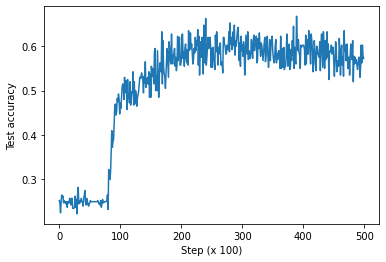

In [14]:
model_k1n4 = train(num_classes=4, num_samples=1, meta_batch_size=64, print_every=100)

Load data completed
*****Iter 0*****
Train Loss: 1.3949090242385864 Test Loss: 1.388342261314392
Test Accuracy 0.2750000059604645
*****Iter 100*****
Train Loss: 1.3849294185638428 Test Loss: 1.388199806213379
Test Accuracy 0.23999999463558197
*****Iter 200*****
Train Loss: 1.384484052658081 Test Loss: 1.3859570026397705
Test Accuracy 0.30250000953674316
*****Iter 300*****
Train Loss: 1.385817050933838 Test Loss: 1.386181354522705
Test Accuracy 0.23000000417232513
*****Iter 400*****
Train Loss: 1.3863074779510498 Test Loss: 1.3861448764801025
Test Accuracy 0.2824999988079071
*****Iter 500*****
Train Loss: 1.3863959312438965 Test Loss: 1.3861912488937378
Test Accuracy 0.2574999928474426
*****Iter 600*****
Train Loss: 1.3862035274505615 Test Loss: 1.3861687183380127
Test Accuracy 0.25999999046325684
*****Iter 700*****
Train Loss: 1.387559413909912 Test Loss: 1.385679006576538
Test Accuracy 0.2574999928474426
*****Iter 800*****
Train Loss: 1.3862420320510864 Test Loss: 1.3859376907348633
T

*****Iter 7300*****
Train Loss: 0.957751452922821 Test Loss: 0.9381015300750732
Test Accuracy 0.6675000190734863
*****Iter 7400*****
Train Loss: 0.9852630496025085 Test Loss: 0.9544745683670044
Test Accuracy 0.637499988079071
*****Iter 7500*****
Train Loss: 0.9568179845809937 Test Loss: 0.9712741374969482
Test Accuracy 0.6324999928474426
*****Iter 7600*****
Train Loss: 0.9854757785797119 Test Loss: 0.9519438147544861
Test Accuracy 0.6424999833106995
*****Iter 7700*****
Train Loss: 0.9451395273208618 Test Loss: 0.9539796710014343
Test Accuracy 0.6775000095367432
*****Iter 7800*****
Train Loss: 0.9606925845146179 Test Loss: 0.9749324917793274
Test Accuracy 0.5899999737739563
*****Iter 7900*****
Train Loss: 0.9527950286865234 Test Loss: 0.9813035726547241
Test Accuracy 0.625
*****Iter 8000*****
Train Loss: 0.9368141293525696 Test Loss: 0.9871482253074646
Test Accuracy 0.6100000143051147
*****Iter 8100*****
Train Loss: 0.9088947772979736 Test Loss: 0.9485753774642944
Test Accuracy 0.677500

*****Iter 14600*****
Train Loss: 0.8028922080993652 Test Loss: 0.8054877519607544
Test Accuracy 0.7674999833106995
*****Iter 14700*****
Train Loss: 0.7652202844619751 Test Loss: 0.8390783071517944
Test Accuracy 0.7124999761581421
*****Iter 14800*****
Train Loss: 0.7513605356216431 Test Loss: 0.8148863911628723
Test Accuracy 0.762499988079071
*****Iter 14900*****
Train Loss: 0.7409629821777344 Test Loss: 0.8037386536598206
Test Accuracy 0.7599999904632568
*****Iter 15000*****
Train Loss: 0.8199115991592407 Test Loss: 0.80409836769104
Test Accuracy 0.7574999928474426
*****Iter 15100*****
Train Loss: 0.7772844433784485 Test Loss: 0.8022866249084473
Test Accuracy 0.7549999952316284
*****Iter 15200*****
Train Loss: 0.7813409566879272 Test Loss: 0.8318832516670227
Test Accuracy 0.7225000262260437
*****Iter 15300*****
Train Loss: 0.7408403158187866 Test Loss: 0.8370465636253357
Test Accuracy 0.7425000071525574
*****Iter 15400*****
Train Loss: 0.7583543062210083 Test Loss: 0.8000160455703735
T

*****Iter 21800*****
Train Loss: 0.7157293558120728 Test Loss: 0.7748938202857971
Test Accuracy 0.7875000238418579
*****Iter 21900*****
Train Loss: 0.7402070760726929 Test Loss: 0.7666690349578857
Test Accuracy 0.7724999785423279
*****Iter 22000*****
Train Loss: 0.692383885383606 Test Loss: 0.787179172039032
Test Accuracy 0.7549999952316284
*****Iter 22100*****
Train Loss: 0.7302436828613281 Test Loss: 0.7682341933250427
Test Accuracy 0.7925000190734863
*****Iter 22200*****
Train Loss: 0.741194486618042 Test Loss: 0.7373400926589966
Test Accuracy 0.8050000071525574
*****Iter 22300*****
Train Loss: 0.7103281617164612 Test Loss: 0.7692096829414368
Test Accuracy 0.7875000238418579
*****Iter 22400*****
Train Loss: 0.7338289618492126 Test Loss: 0.794901967048645
Test Accuracy 0.7549999952316284
*****Iter 22500*****
Train Loss: 0.7175299525260925 Test Loss: 0.7509948015213013
Test Accuracy 0.7950000166893005
*****Iter 22600*****
Train Loss: 0.7463138699531555 Test Loss: 0.7571150064468384
Te

*****Iter 29000*****
Train Loss: 0.6803167462348938 Test Loss: 0.7671670317649841
Test Accuracy 0.7724999785423279
*****Iter 29100*****
Train Loss: 0.681031346321106 Test Loss: 0.7578617334365845
Test Accuracy 0.7925000190734863
*****Iter 29200*****
Train Loss: 0.6855258345603943 Test Loss: 0.7427515387535095
Test Accuracy 0.7925000190734863
*****Iter 29300*****
Train Loss: 0.7160763740539551 Test Loss: 0.7353744506835938
Test Accuracy 0.8199999928474426
*****Iter 29400*****
Train Loss: 0.6572611927986145 Test Loss: 0.7377981543540955
Test Accuracy 0.7799999713897705
*****Iter 29500*****
Train Loss: 0.6686335802078247 Test Loss: 0.7659950256347656
Test Accuracy 0.7649999856948853
*****Iter 29600*****
Train Loss: 0.6763114929199219 Test Loss: 0.6955060362815857
Test Accuracy 0.8450000286102295
*****Iter 29700*****
Train Loss: 0.6809987425804138 Test Loss: 0.7246999144554138
Test Accuracy 0.8050000071525574
*****Iter 29800*****
Train Loss: 0.6698639988899231 Test Loss: 0.7255532741546631

*****Iter 36200*****
Train Loss: 0.658224880695343 Test Loss: 0.7334302663803101
Test Accuracy 0.8149999976158142
*****Iter 36300*****
Train Loss: 0.6550993323326111 Test Loss: 0.6890255212783813
Test Accuracy 0.8349999785423279
*****Iter 36400*****
Train Loss: 0.6630321741104126 Test Loss: 0.7716444134712219
Test Accuracy 0.7900000214576721
*****Iter 36500*****
Train Loss: 0.6469707489013672 Test Loss: 0.7360482215881348
Test Accuracy 0.7850000262260437
*****Iter 36600*****
Train Loss: 0.6949248313903809 Test Loss: 0.7009212970733643
Test Accuracy 0.8450000286102295
*****Iter 36700*****
Train Loss: 0.6495163440704346 Test Loss: 0.7368249297142029
Test Accuracy 0.7950000166893005
*****Iter 36800*****
Train Loss: 0.6598707437515259 Test Loss: 0.7404437065124512
Test Accuracy 0.8025000095367432
*****Iter 36900*****
Train Loss: 0.6497732996940613 Test Loss: 0.7464771270751953
Test Accuracy 0.7925000190734863
*****Iter 37000*****
Train Loss: 0.676921010017395 Test Loss: 0.7261955738067627


*****Iter 43400*****
Train Loss: 0.6404866576194763 Test Loss: 0.7207188606262207
Test Accuracy 0.8100000023841858
*****Iter 43500*****
Train Loss: 0.627400279045105 Test Loss: 0.7455713748931885
Test Accuracy 0.7850000262260437
*****Iter 43600*****
Train Loss: 0.6354967355728149 Test Loss: 0.7201635837554932
Test Accuracy 0.8274999856948853
*****Iter 43700*****
Train Loss: 0.6393386125564575 Test Loss: 0.715735912322998
Test Accuracy 0.8274999856948853
*****Iter 43800*****
Train Loss: 0.6248970627784729 Test Loss: 0.7470373511314392
Test Accuracy 0.7699999809265137
*****Iter 43900*****
Train Loss: 0.6262340545654297 Test Loss: 0.727672815322876
Test Accuracy 0.8174999952316284
*****Iter 44000*****
Train Loss: 0.611491322517395 Test Loss: 0.728116512298584
Test Accuracy 0.7799999713897705
*****Iter 44100*****
Train Loss: 0.6426757574081421 Test Loss: 0.737118661403656
Test Accuracy 0.8149999976158142
*****Iter 44200*****
Train Loss: 0.6447244882583618 Test Loss: 0.6779100894927979
Test

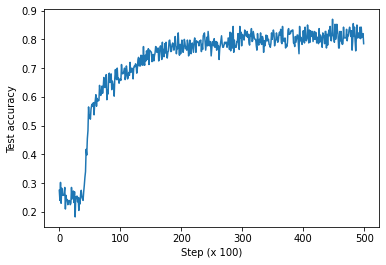

In [15]:
model_k5n4 = train(num_classes=4, num_samples=5, meta_batch_size=64, print_every=100)

### Vissualize some predictions

In [26]:
num_classes = 4
num_samples = 1

In [27]:
data_generator = DataGeneratorPreFetch(num_classes=4, num_samples_per_class=num_samples+1)

Load data completed


torch.Size([20, 4, 4])


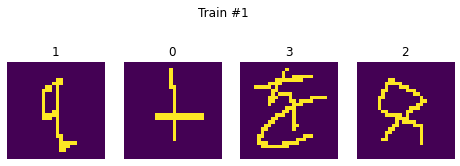

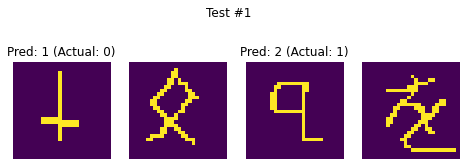

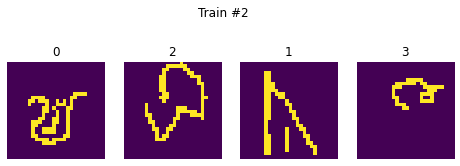

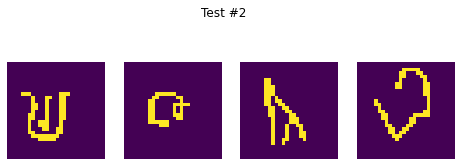

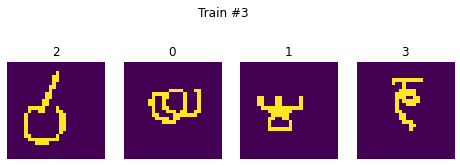

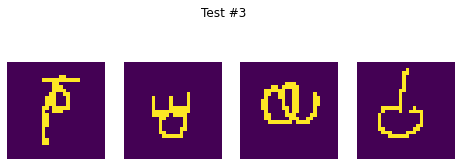

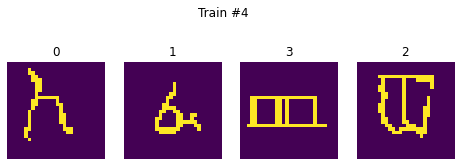

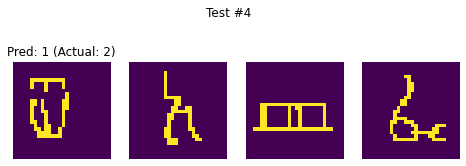

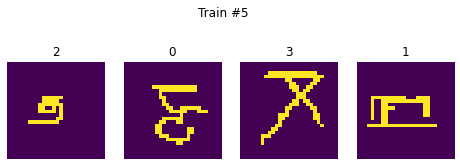

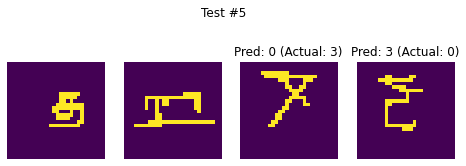

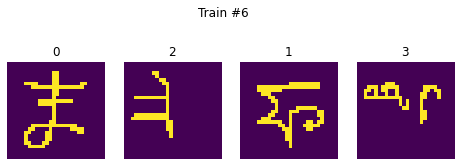

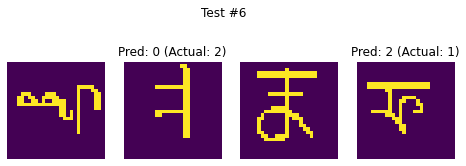

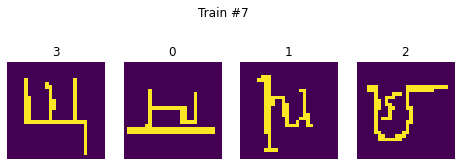

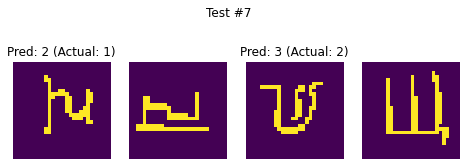

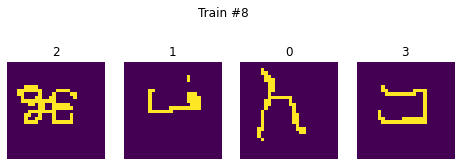

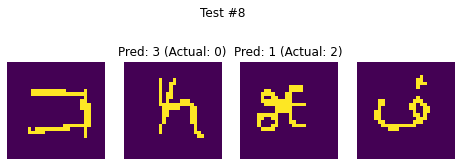

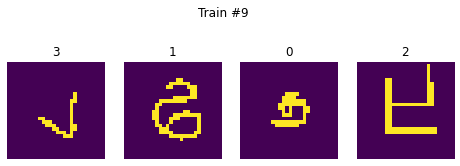

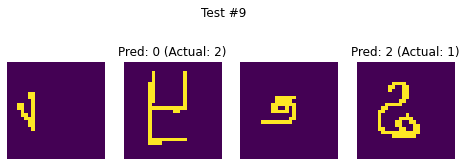

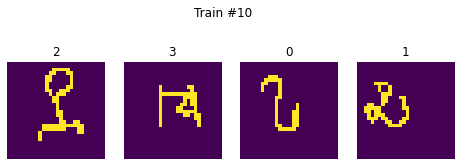

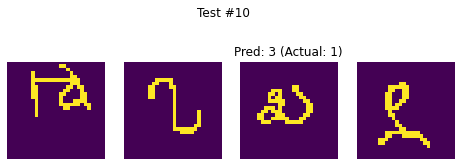

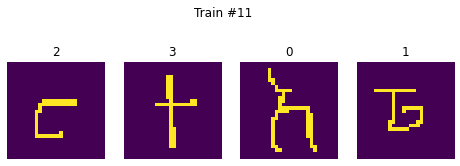

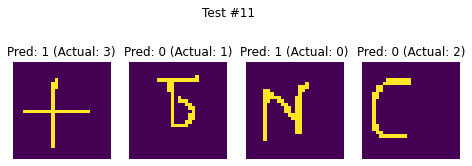

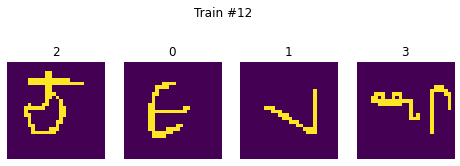

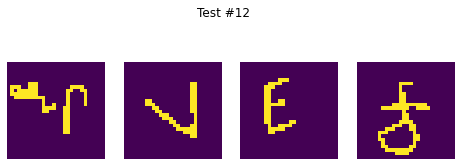

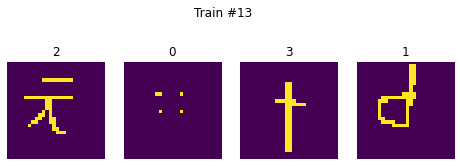

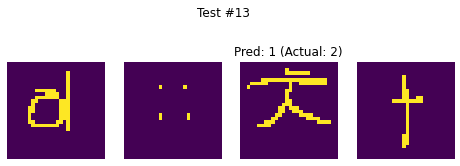

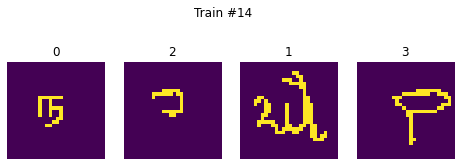

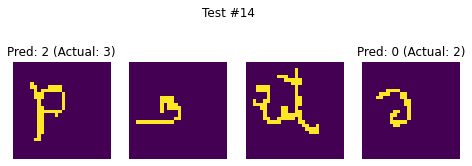

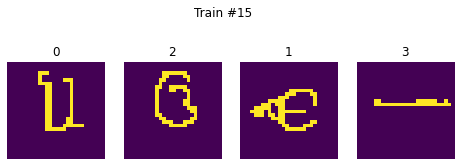

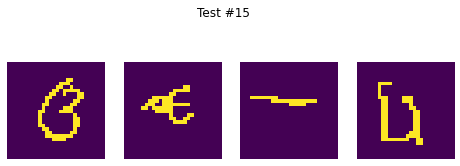

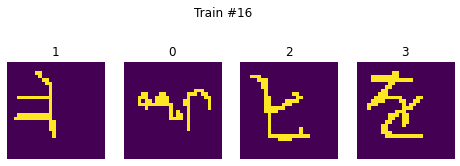

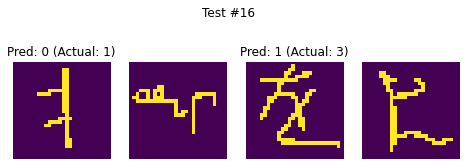

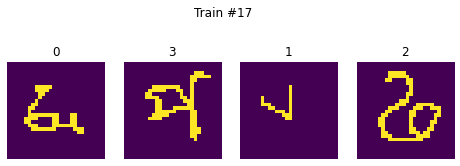

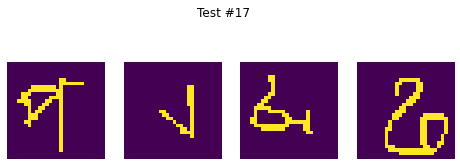

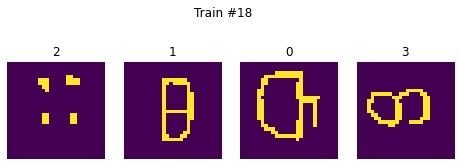

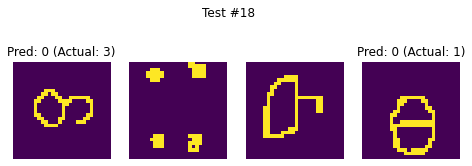

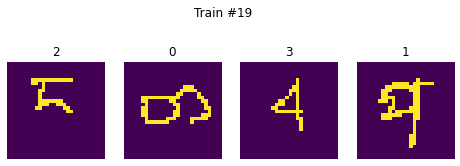

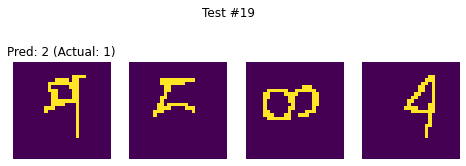

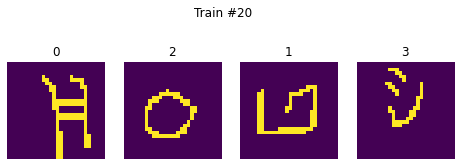

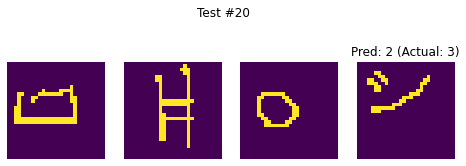

In [28]:
batch_images, batch_labels = data_generator.sample_batch('test', batch_size=20)

with torch.no_grad():
    batch_labels_infer = batch_labels.copy()
    last_n_step_labels = batch_labels[:, -1:]
    last_n_step_labels = last_n_step_labels.squeeze(1).reshape(-1, num_classes)  # (B * N, N)
    logits = model_k1n4(batch_images, batch_labels_infer)
    last_n_step_logits = logits[-num_classes:].transpose(0, 1).contiguous()
    print(last_n_step_logits.shape)

for i in range(20):
    images, labels, predictions = batch_images[i], batch_labels[i], last_n_step_logits[i]
    train_images, train_labels = images[:-1].reshape(-1, 28, 28), labels[:-1].reshape(-1, num_classes)  # K-1, N, N
    test_images, test_labels = images[-1:].reshape(-1, 28, 28), labels[-1:].reshape(-1, num_classes) # 1, N, N
    
    plot_prediction(train_images, train_labels, n_col=num_classes, title=f'Train #{i+1}')
    plot_prediction(test_images, test_labels, predictions, n_col=num_classes, title=f'Test #{i+1}')